# Name: Ahmed Yousri Ali

In [1]:
#!pip install tensorflow-datasets

In [2]:
#!pip install tensorflow

In [20]:
# Importations

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random as rn

### Loading Dataset

In [4]:
(train, test) , info = tfds.load(name="emnist", split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

In [5]:
# Info about dataset
info

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\ayous\\tensorflow_datasets\\emnist\\byclass\\3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
   

### Convert data into numpy

In [6]:
def extract_data(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
        
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Extract training and test data
train_images, train_labels = extract_data(train)
test_images, test_labels = extract_data(test)

In [7]:
# Print Data dimensions and size
print("Train Images Shape: ", train_images.shape)
print("Train Labels Shape: ", train_labels.shape)
print("Test Images Shape: ", test_images.shape)
print("Test Labels Shape: ", test_labels.shape)
print("Number of classes: ", len(np.unique(train_labels)) , "Classes")


Train Images Shape:  (697932, 28, 28, 1)
Train Labels Shape:  (697932,)
Test Images Shape:  (116323, 28, 28, 1)
Test Labels Shape:  (116323,)
Number of classes:  62 Classes


### Normalize data to [0,1]

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### Plot some training data

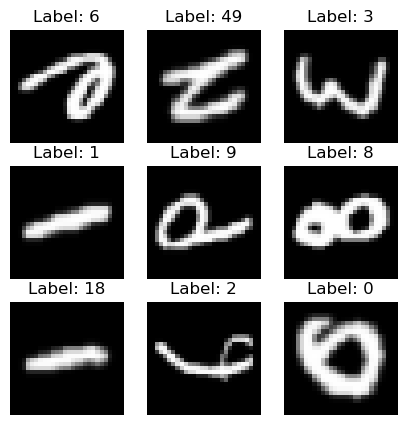

In [9]:
num_samples = 9
plt.figure(figsize=(5, 5))

for i in range(num_samples):
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid
    image = train_images[i].reshape(28, 28)  # Reshape to 28x28
    label = train_labels[i]
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()

### Data batching


In [10]:
datagen = ImageDataGenerator()

train_gen = datagen.flow(train_images,train_labels, batch_size=128) # augmentation and make batch size 128
val_gen = datagen.flow( test_images, test_labels, batch_size=128)# augmentation and make batch size 128

### Building Model

#### Early Stopping

In [11]:
es = EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=8, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #restore the best weight
)

#### Model Architecture

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation='softmax')
])
model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,607,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,304,318 (16.42 MB)

 Trainable params: 4,304,318 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='Adamax',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_gen, epochs=20, validation_data=val_gen , callbacks=[es])

Epoch 1/20


d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 194s 35ms/step - accuracy: 0.7563 - loss: 0.8191 - val_accuracy: 0.8407 - val_loss: 0.4515
Epoch 2/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 188s 34ms/step - accuracy: 0.8490 - loss: 0.4219 - val_accuracy: 0.8515 - val_loss: 0.4122
Epoch 3/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 189s 35ms/step - accuracy: 0.8610 - loss: 0.3771 - val_accuracy: 0.8512 - val_loss: 0.4032
Epoch 4/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 190s 35ms/step - accuracy: 0.8685 - loss: 0.3507 - val_accuracy: 0.8589 - val_loss: 0.3887
Epoch 5/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 181s 33ms/step - accuracy: 0.8733 - loss: 0.3299 - val_accuracy: 0.8582 - val_loss: 0.3848
Epoch 6/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 186s 34ms/step - accuracy: 0.8787 - loss: 0.3131 - val_accuracy: 0.8611 - val_loss: 0.3873
Epoch 7/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 189s 35ms/step - accuracy: 0.8827 - loss: 0.2991 - val_accuracy: 0.8606 - val_loss: 0.3878
Epoch 8/20
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 184s 34ms/step - accuracy: 0.8869 - lo

# The accuracy got about 92%

In [14]:
# To save the model and the weight of it
model.save('D:/College/my_communication/assignment/Day_6/saves/NN_model.keras')
model.save_weights('D:/College/my_communication/assignment/Day_6/saves/NN_model_weigh.weights.h5')
#To load the mode and weight
# model = tf.keras.models.load_model('D:/College/my_communication/assignment/Day_6/saves/NN_model.keras')
# model.load_weights('D:/College/my_communication/assignment/Day_6/saves/NN_model_weigh.weights.h5')

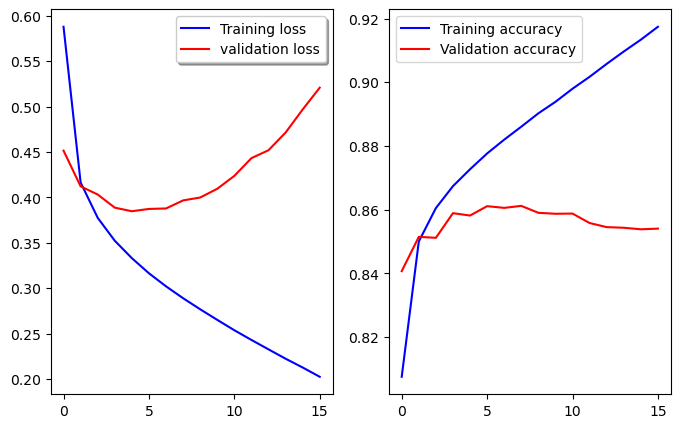

In [19]:

fig, ax = plt.subplots(1,2, figsize=(8, 5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend()

In [16]:
# evaluate the model
model.evaluate(test_images, test_labels)

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8614 - loss: 0.3959


[0.3966788351535797, 0.8611968159675598]

In [22]:
test_pred = model.predict(test_images)
test_pred_labels = np.argmax(test_pred, axis=1)

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


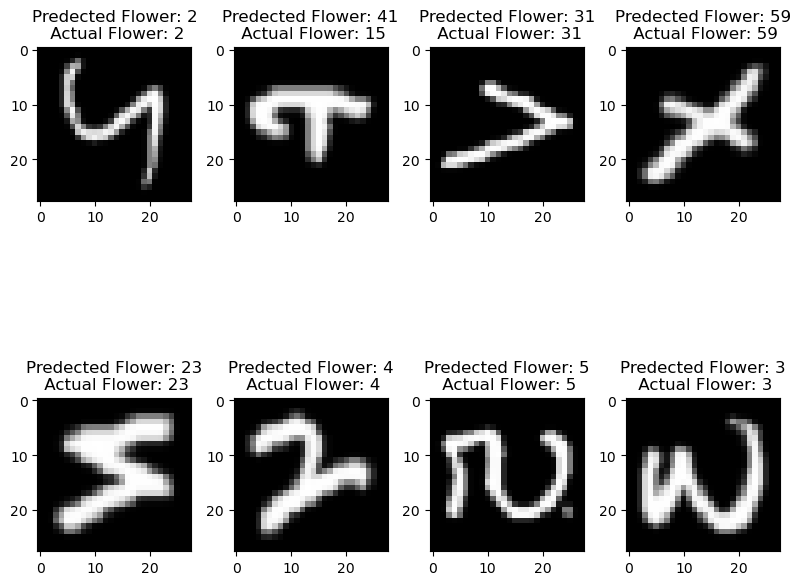

In [47]:
fig,ax=plt.subplots(2,4)
fig.set_size_inches(8,8)
for i in range(2):
    for j in range (4):
        l=rn.randint(0,len(test_pred_labels)-1)
        ax[i,j].imshow(test_images[l],cmap='gray')
        ax[i,j].set_title('Predected Flower: ' + str(test_pred_labels[l]) + '\n Actual Flower: '+ str(test_labels[l]))

plt.tight_layout()